<a href="https://colab.research.google.com/github/wayne123512/multi-layer-population-game/blob/main/multi_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simulation for multi-layer framework**

# Utilities

In [1]:
import numpy as np
# utilities
def transform_to3d(data2D: np.ndarray) -> np.ndarray:
  n = len(data2D)
  res = np.zeros((n, 3))
  res[:,1] = data2D[:,1] * 2 / np.sqrt(3)
  res[:,0] = 1 - data2D[:,0] - res[:,1]/2
  res[:,2] = 1 - res[:,0] - res[:,1]

  return res

def transform_to2d(data3D: np.ndarray) -> np.ndarray:
  n = len(data3D)
  res = np.zeros((n, 2))
  res[:,0] = 1 - (data3D[:,0] + data3D[:,1]/2)
  res[:,1] = data3D[:,1] * np.sqrt(3)/2

  return res

def dist(start: np.ndarray, end: np.ndarray):
  return np.linalg.norm(start-end)


# Generate a grid over the 3-simplex
def generate_simplex_grid(n=30):
    points = []
    for i in range(n+1):
        for j in range(n+1 - i):
            k = n - i - j
            x = i / n
            y = j / n
            z = k / n
            points.append([x, y, z])
    return np.array(points)

# Class Definitions:

In [2]:
from scipy.integrate import odeint, solve_ivp
from copy import deepcopy
import cvxpy as cp
from abc import ABC, abstractmethod
from typing import override

# Class Constraint

In [3]:
class Constraint:
  """TODO"""
  "<=0"
  def __init__(self, func, grad=None):
    self.func = func
    self.grad = grad
    self.need_draw = False  # those used by EDM will be turned true in add_constraint

# Class EDM_Block

In [4]:
class EDM_Block(ABC):
  """ TODO """
  def __init__(self, xInit):
    self._dim = len(xInit)
    self._constrs = []
    self._x = np.array(xInit)

  def __str__(self):
    pass


  @property
  def x(self):
    return self._x

  @x.setter
  def x(self, newX):
    self._x = newX

  @abstractmethod
  def model(self,  payoff) -> np.ndarray:
    pass


class BNN(EDM_Block):
  def __init__(self, xInit):
    super().__init__(xInit)

  @override
  def model(self, payoff):
    rho = payoff - self._x @ payoff
    rho[rho < 0] = 0
    rho = np.repeat(rho[np.newaxis,:], self._dim, axis = 0)
    return rho.T @ self._x - self._x * np.sum(rho, axis=1)

class IPC(EDM_Block):
  def __init__(self, xInit):
    super().__init__(xInit)

  @override
  def model(self, payoff):
    rho = payoff - payoff.reshape((-1,1))
    rho[rho < 0] = 0
    return rho.T @ self._x - self._x * np.sum(rho, axis=1)


class Static(EDM_Block):
  def __init__(self, xInit):
    # xInit should not be None
    super().__init__(xInit)

  @override
  def model(self, payoff):
    return 0.0

class BR(EDM_Block):

  def __init__(self, xInit):
    super().__init__(xInit)
    self._constrs.append(Constraint(lambda x, dim=self._dim: np.ones((dim,))@x - 1))
    self._constrs.append(Constraint(lambda x, dim=self._dim: -np.ones((dim,))@x + 1))

  def add_a_constraint(self, constr):
    constr.need_draw =True
    self._constrs.append(constr)

  @override
  def model(self, payoff):
    s = cp.Variable(self._dim, nonneg=True)
    cost = s @ payoff
    constrs = []
    for i in range(len(self._constrs)):
      constrs.append(self._constrs[i].func(s) <= 0)
    prob = cp.Problem(cp.Maximize(cost), constrs)
    prob.solve()

    return s.value - self._x


class Proj(EDM_Block):
  def __init__(self, xInit):
    super().__init__(xInit)
    for i in range(self._dim):
      self._constrs.append(Constraint(lambda x, i=i: -x[i], lambda x, i=i: -np.eye(self._dim)[i]))

  def add_a_constraint(self, constr):
    constr.need_draw =True
    self._constrs.append(constr)

  @override
  def model(self, payoff) -> np.ndarray:
    # 1. Identify active constraints
    active_grad = []
    for i in range(len(self._constrs)):
      if isinstance(self._constrs[i].func(self._x), cp.Expression):
        val = self._constrs[i].func(self._x).value
      else:
        val = self._constrs[i].func(self._x)

      if val >= -1e-6:
        active_grad.append(self._constrs[i].grad(self._x))
    # if no active boudary, project payoff directly
    if len(active_grad) == 0:
      return payoff - np.average(payoff)

    # 2. Define the constraints for the solver: active_grad * d <= 0
    active_grad = np.array(active_grad)
    # add simplex surface constraints
    active_grad = np.vstack((active_grad, np.array([np.ones((self._dim,)),-np.ones((self._dim,))])))

    # 3. Solve the QP
    v = cp.Variable(self._dim)
    cost = cp.sum_squares(v-payoff)
    constrs = [ active_grad @ v <= 0]
    prob = cp.Problem(cp.Minimize(cost), constrs)
    prob.solve()

    return v.value



## Class PDM_Block

In [5]:
class PDM_Block(ABC):
  """ TODO """
  def __init__(self, dim, qInit=None):
    self._dim = dim
    self._q = np.array(qInit) if qInit is not None else np.zeros((dim,))

  def __str__(self):
    pass

  @property
  def q(self):
    return self._q

  @q.setter
  def q(self, newQ):
    self._q = newQ

  @abstractmethod
  def evaluate(self, x) -> np.ndarray:
    pass

  @abstractmethod
  def model(self, x) -> np.ndarray:
    pass

class Game(PDM_Block):
  def __init__(self, dim):
    super().__init__(dim)

  def __str__(self):
    pass

  @override
  def model(self, x):
    return np.zeros((self._dim,))


class Distance(Game):
  def __init__(self, starts, ends):
    super().__init__(len(starts)*len(ends))
    self._starts = np.array(starts)    # starts positions
    self._ends = np.array(ends)        # target positions
    self._constants = -1.0 * np.array([dist(i,j) for i in self._starts for j in self._ends])

  @override
  def evaluate(self, x):
    return self._constants

class CongestedDistance(Distance) :
  def __init__(self, starts, ends, coeffs):
    super().__init__(starts, ends)
    assert self._dim == len(coeffs), "[Congestion] Length mismatch for coeffs"
    self._coeffs = -1.0 * np.array(coeffs)

  @override
  def evaluate(self, x):
    return 1*(self._coeffs * x + self._constants)

class Congestion(Game):
  def __init__(self, R, m, n):
    super().__init__(len(R))
    self._R = np.array(R)
    self._m = np.diag(m)
    self._n = np.array(n)

  @override
  def evaluate(self, x):
    return -1* self._R @ (self._m @ self._R.T @ x + self._n)

class RPS(Game):
  def __init__(self, dim, reverse=False):
    super().__init__(dim)
    self._A = np.zeros((dim, dim))
    for i in range(dim):
      j = (i + 1) % dim
      self._A[i, j] = -1 if not reverse else 1
      self._A[j, i] = 1 if not reverse else -1

  @override
  def evaluate(self, x):

    return 10*self._A @ x

class Constant(Game):
  def __init__(self, constants):
    super().__init__(len(constants))
    self._constants = np.array(constants)

  @override
  def evaluate(self, x):
    return self._constants

class DynamicGame(PDM_Block):
  def __init__(self, qInit):
    super().__init__(len(qInit), qInit)

  def __str__(self):
    pass


class Queue(DynamicGame):
  def __init__(self, qInit, genRate, serviceRate, abandonRate, gain):
    super().__init__(qInit)
    assert self._dim == len(genRate) and self._dim == len(serviceRate) and self._dim == len(abandonRate) and self._dim == len(gain), "Length mismatch"
    self._genRate = np.array(genRate)
    self._serviceRate = np.array(serviceRate)
    self._abandonRate = np.array(abandonRate)
    self._gain = np.array(gain)

  @override
  def evaluate(self, x):
    return 1./self._abandonRate * (self._genRate - self._serviceRate * x + self._gain * (self._genRate - self._serviceRate * x - self._abandonRate * self._q))

  @override
  def model(self, x) -> np.ndarray:
    return self._genRate - self._serviceRate * x - self._abandonRate * self._q

# Class Network

In [6]:
class Network:
  """ TODO: generate main flow through network config """
  pass

# Main Flow:

In [7]:
# initial conditions for EDMs
s110 = np.array([1/3,1/3,1/3])
s210 = np.array([0.2,0.1,0.7])
s220 = np.array([0.2,0.6,0.2])
s230 = np.array([0.65,0.15,0.2])


# define useful constriants
constraints = []
constraints.append(Constraint(lambda x: -x[2]+0.1, lambda x: np.array([0,0,-1])))
constraints.append(Constraint(lambda x: x[1]-0.9, lambda x: np.array([0,1,0])))
constraints.append(Constraint(lambda x: -x[0]+0.1, lambda x: np.array([-1,0,0])))
# constraints.append(Constraint(lambda x: (x[0]-1/3)**2+(x[1]-1/3)**2+(x[2]-1/3)**2 -0.36, lambda x: 2*(x-np.array([1/3,1/3,1/3]))))
constraints.append(Constraint(lambda x: cp.sum_squares(x-np.array([1/3,1/3,1/3]))-0.25, lambda x: 2*(x-np.array([1/3,1/3,1/3]))))
constraints.append(Constraint(lambda x: -x[0]+0.1, lambda x: np.array([-1,0,0])))

# s11 = BR(s110)
# s21 = BR(s210)
# s22 = BR(s220)
# s23 = BR(s230)
s11 = Proj(s110)
s21 = Proj(s210)
s22 = Proj(s220)
s23 = Proj(s230)
# s11 = IPC(s110)
# s21 = IPC(s210)
# s22 = IPC(s220)
# s23 = IPC(s230)

# test constraints for BR or Proj
s11.add_a_constraint(constraints[3])
# s21.add_a_constraint(constraints[0])
s21.add_a_constraint(constraints[3])
# s22.add_a_constraint(constraints[1])
s22.add_a_constraint(constraints[3])
# s23.add_a_constraint(constraints[2])
s23.add_a_constraint(constraints[3])


# initial conditions for PDMs
qp20 = [0,0,0]
qpf0 = [0,0,0]

# utility rewards & decision rewards
p2 = Queue(qp20, np.array([1,1,1]), np.array([0.3,0.2,0.2]), 0.5*np.array([1,1,1]), np.array([0.2,0.2,0.2])) # g, mu, lam, k : g > mu
pf = Queue(qpf0, np.array([1.3,2,1.5]), np.array([0.9,0.4,0.5]), 0.5*np.array([1,1,1]), np.array([0.1,0.2,0.2]))
r1 = Congestion([[1,1,0,0,0],[0,0,1,1,0],[1,0,0,1,1]], [1,0,0,1,0], [0,1,1,0,0])
r2 = Distance(np.array([[1,0],[0.5,0.5],[0,1]]), np.array([[2,0],[-1,-1],[0,2]]))

# demonstrate cycling for monotone games
# p2 = Constant(np.zeros((3,)))
# pf = RPS(3)
# r1 = Constant(np.zeros((3,)))
# r2 = Constant(np.zeros((9,)))


W2 = np.array([[1,0,0,1,0,0,1,0,0],
               [0,1,0,0,1,0,0,1,0],
               [0,0,1,0,0,1,0,0,1]])

# do simulations
data = np.array([*s110, *s210, *s220, *s230, *qp20, *qpf0, *np.zeros((12,))])
t_start = 0
t_end = 20
time = t_start
dt = 0.005  #0.005

# record data
resData = []
t = []
resX = []
resPi1 = []
resPi2 = []
resPathPi = []


def simulation(t, data):
  # extract data
  s11.x = data[:3]
  s21.x = data[3:6]
  s22.x = data[6:9]
  s23.x = data[9:12]
  p2.q = data[12:15]
  pf.q = data[15:18]
  r1.q = data[18:21]
  r2.q = data[21:] #[21:30]

  # define intermediate variables
  # m1 = 1
  # m2 = o1 = s11Data
  ts21 = s21.x * s11.x[0]
  ts22 = s22.x * s11.x[1]
  ts23 = s23.x * s11.x[2]
  o2 = np.array([*ts21, *ts22, *ts23])
  x = W2 @ o2
  resX.append(x)

  # determine payoffs
  p2Val = p2.evaluate(s11.x)
  pfVal = pf.evaluate(x)
  r1Val = r1.evaluate(s11.x)
  r2Val = r2.evaluate(o2)

  pi2Val = r2Val + W2.T@pfVal
  pi1Val = r1Val + p2Val + np.array([s21.x@pi2Val[:3], s22.x@pi2Val[3:6], s23.x@pi2Val[6:]])
  resPi2.append(pi2Val)
  resPi1.append(pi1Val)
  resPathPi.append(np.array([*(pi2Val[:3]+r1Val[0]+p2Val[0]), *(pi2Val[3:6]+r1Val[1]+p2Val[1]), *(pi2Val[6:]+r1Val[2]+p2Val[2])]))

  # calculate dt
  ds11 = s11.model(pi1Val)
  ds21 = s21.model(pi2Val[:3])
  ds22 = s22.model(pi2Val[3:6])
  ds23 = s23.model(pi2Val[6:])
  dqp2 = p2.model(s11.x)
  dqpf = pf.model(x)
  dqr1 = r1.model(s11.x)
  dqr2 = r2.model(o2)

  return np.array([*ds11, *ds21, *ds22, *ds23, *dqp2, *dqpf, *dqr1, *dqr2])


# main simulation
while time < t_end:
  resData.append(deepcopy(data))
  t.append(time)
  ddatadt = simulation(time, data)
  if (np.linalg.norm(ddatadt) < 1e-3):
    break
  # update
  data += dt * ddatadt
  time += dt

In [8]:
resData = np.array(resData)
resX = np.array(resX)
resPi2 = np.array(resPi2)
resPi1 = np.array(resPi1)
resPathPi = np.array(resPathPi)
resS11 = resData[:,:3]
resS21 = resData[:,3:6]
resS22 = resData[:,6:9]
resS23 = resData[:,9:12]

# Plot Utilities:

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from functools import partial
from matplotlib import rc
rc('animation', html='jshtml')

# Run the following two lines to install latex fonts & environments
# !apt-get update
# !apt-get install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

# Update rcParams to use LaTeX
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

# Plot results

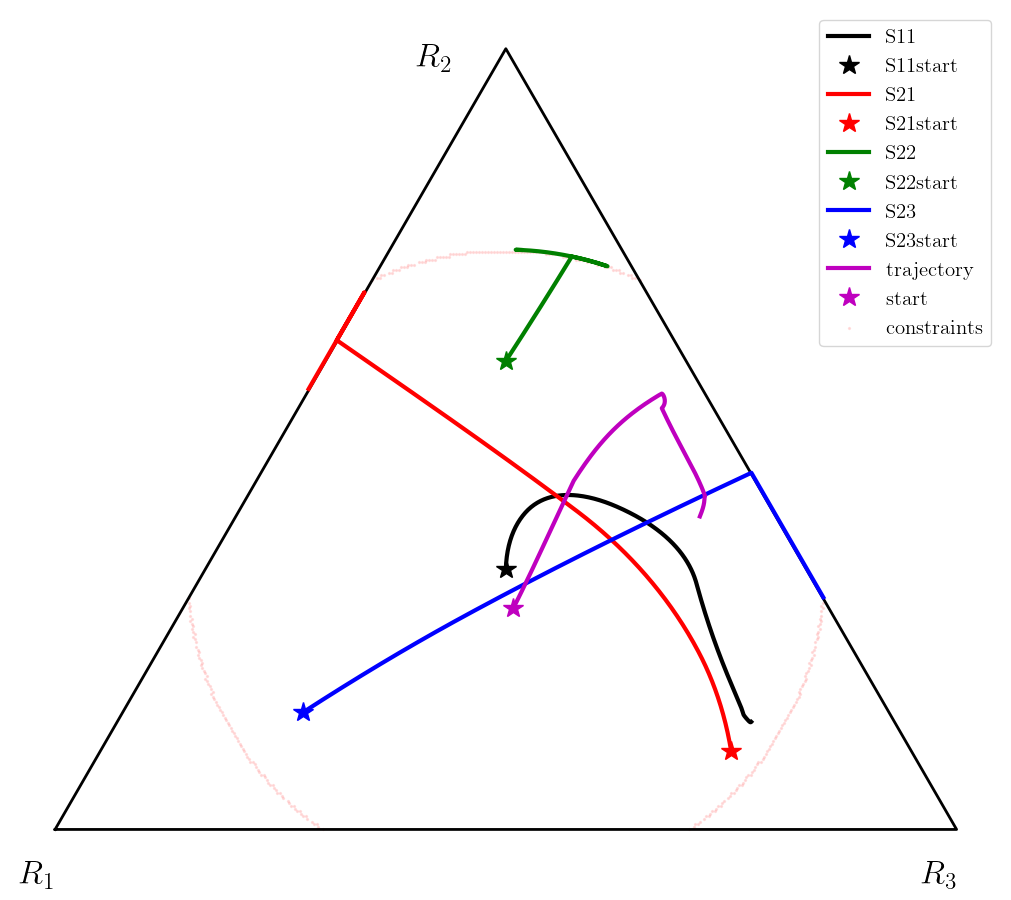

In [14]:
# All-in-one figure
ss = 24
ms = 15
ls = 15
f = plt.figure(layout="constrained", figsize=(10,10))
ax = f.subplot_mosaic("""T""")
# plot simplex
ax["T"].set_aspect('equal')
ax["T"].set_axis_off()
ax["T"].plot([0, 1, 1/2, 0],[0, 0, np.sqrt(3)/2, 0], 'k-', linewidth=2)

# Label the vertices
id_mtx = np.identity(3)
res_vertices = transform_to2d(id_mtx)
labels = [r'$R_1$', r'$R_2$', r'$R_3$']
offsets = [(-0.04, -0.06), (-0.1, -0.02), (-0.04, -0.06)] # Adjusted for readability

for i, data in enumerate(res_vertices):
    ax["T"].text(data[0] + offsets[i][0], data[1] + offsets[i][1], labels[i], fontsize=ss)


# plot intermediate trajectories
res_S11 =transform_to2d(resS11)
ax["T"].plot(res_S11[:,0], res_S11[:,1], 'k-', linewidth=3, label='S11')
ax["T"].plot(res_S11[0,0], res_S11[0,1], 'k*', markersize=ms, label='S11start')
res_S21 =transform_to2d(resS21)
ax["T"].plot(res_S21[:,0], res_S21[:,1], 'r-', linewidth=3, label='S21')
ax["T"].plot(res_S21[0,0], res_S21[0,1], 'r*', markersize=ms, label='S21start')
res_S22 =transform_to2d(resS22)
ax["T"].plot(res_S22[:,0], res_S22[:,1], 'g-', linewidth=3, label='S22')
ax["T"].plot(res_S22[0,0], res_S22[0,1], 'g*', markersize=ms, label='S22start')
res_S23 =transform_to2d(resS23)
ax["T"].plot(res_S23[:,0], res_S23[:,1], 'b-', linewidth=3, label='S23')
ax["T"].plot(res_S23[0,0], res_S23[0,1], 'b*', markersize=ms, label='S23start')

# plot recorded trajectory
res_Traj = transform_to2d(resX)
ax["T"].plot(res_Traj[:,0], res_Traj[:,1], 'm-', linewidth=3, label='trajectory')
ax["T"].plot(res_Traj[0,0], res_Traj[0,1], 'm*', markersize=ms, label='start')

# ax["T"].set_title("trajectory projected to 2D", fontsize=ss)

# plot constraints
K = generate_simplex_grid(n=300)
bd = []
for k in K:
  for constr in constraints:
    if not constr.need_draw:
      continue

    if isinstance(constr.func(k), cp.Expression):
      if np.abs(constr.func(k).value) < 2e-3:
        bd.append(k)
        break
    else:
      if np.abs(constr.func(k)) <5e-4:
        bd.append(k)
        break
if len(bd) > 0:
  bd = np.array(bd)
  res_bd = transform_to2d(bd)
  ax["T"].scatter(res_bd[:,0], res_bd[:,1], color='r', s=2, alpha=0.1, label='constraints')

ax["T"].legend(loc='upper right', fontsize=ls)

In [15]:
# for verification with the plot results
print('pi11: {}'.format(resPi1[-1,:]))
print('pi21: {}'.format(resPi2[-1,:3]))
print('pi22: {}'.format(resPi2[-1,3:6]))
print('pi23: {}'.format(resPi2[-1,6:]))

pi11: [1.48899575 1.48914422 1.48909893]
pi21: [1.4481454  1.44338885 0.249147  ]
pi22: [0.86700657 1.55813648 0.90407615]
pi23: [0.21207743 1.44338885 1.48521498]


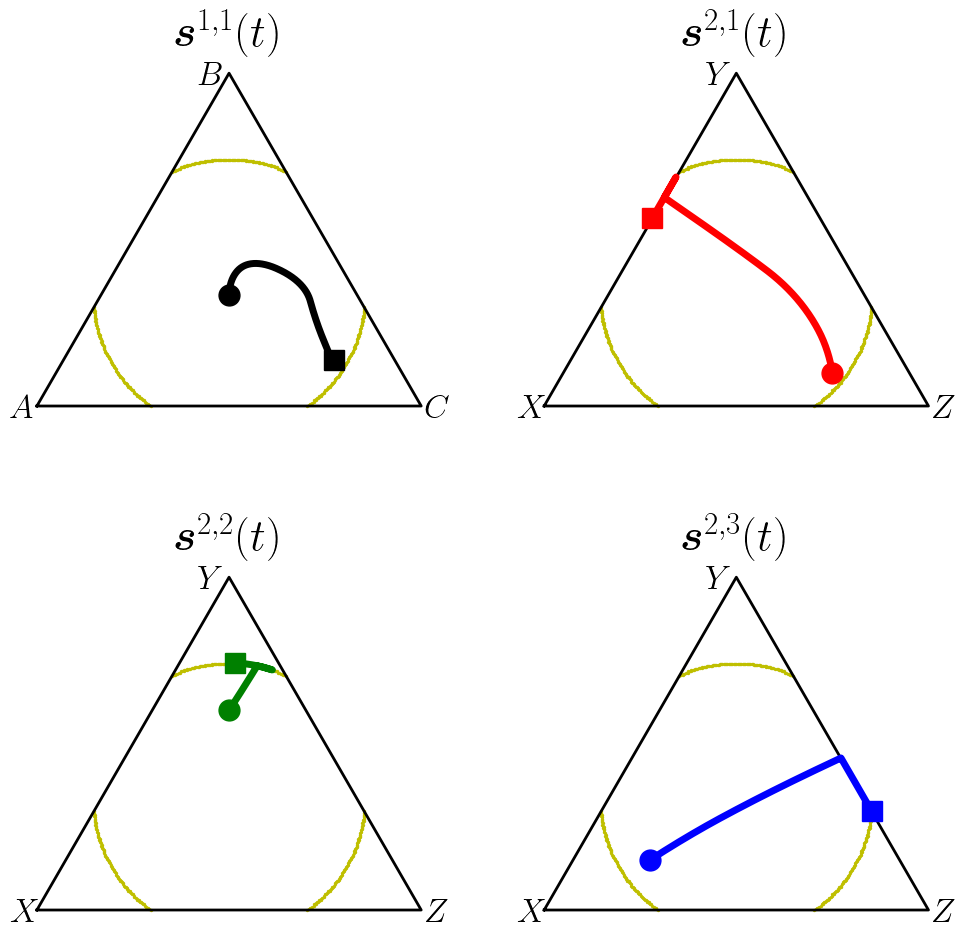

In [16]:
# fig for TCNS: mid trajectories sij
fs = 32
ss = 24
ms = 15
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axes_list = axes.flatten()

# plot simplex
for i in range(axes.shape[0]):
  for j in range(axes.shape[1]):
    axis = axes[i][j]
    axis.set_aspect('equal')
    axis.set_axis_off()
    axis.plot([0, 1, 1/2, 0],[0, 0, np.sqrt(3)/2, 0], 'k-', linewidth=2)
    axis.scatter(res_bd[:,0], res_bd[:,1], color='y', s=2, label='constraints')

# Label the vertices
id_mtx = np.identity(3)
res_vertices = transform_to2d(id_mtx)
offsets = [(-0.07, -0.03), (-0.08, -0.03), (0.01, -0.03)] # Adjusted for readability

labelABC = [r'$A$', r'$B$', r'$C$']
labelXYZ = [r'$X$', r'$Y$', r'$Z$']
for i, data in enumerate(res_vertices):
  for idx in range(len(axes_list)):
    if idx == 0:
      axes_list[0].text(data[0] + offsets[i][0], data[1] + offsets[i][1], labelABC[i], fontsize=ss)
    else:
      axes_list[idx].text(data[0] + offsets[i][0], data[1] + offsets[i][1], labelXYZ[i], fontsize=ss)

axes[0][0].set_title("{}".format(r'$\bm{s}^{1,1}(t)$'), fontsize=fs)
axes[0][1].set_title("{}".format(r'$\bm{s}^{2,1}(t)$'), fontsize=fs)
axes[1][0].set_title("{}".format(r'$\bm{s}^{2,2}(t)$'), fontsize=fs)
axes[1][1].set_title("{}".format(r'$\bm{s}^{2,3}(t)$'), fontsize=fs)

axes[0][0].plot(res_S11[:,0], res_S11[:,1], 'k-', linewidth=5, label='S11')
axes[0][0].plot(res_S11[0,0], res_S11[0,1], 'ko', label='S11start', markersize=ms)
axes[0][0].plot(res_S11[-1,0], res_S11[-1,1], 'ks', label='S11end', markersize=ms)

axes[0][1].plot(res_S21[:,0], res_S21[:,1], 'r-', linewidth=5, label='S21')
axes[0][1].plot(res_S21[0,0], res_S21[0,1], 'ro', label='S21start', markersize=ms)
axes[0][1].plot(res_S21[-1,0], res_S21[-1,1], 'rs', label='S21end', markersize=ms)

axes[1][0].plot(res_S22[:,0], res_S22[:,1], 'g-', linewidth=5, label='S22')
axes[1][0].plot(res_S22[0,0], res_S22[0,1], 'go', label='S22start', markersize=ms)
axes[1][0].plot(res_S22[-1,0], res_S22[-1,1], 'gs', label='S22end', markersize=ms)

axes[1][1].plot(res_S23[:,0], res_S23[:,1], 'b-', linewidth=5, label='S23')
axes[1][1].plot(res_S23[0,0], res_S23[0,1], 'bo', label='S23start', markersize=ms)
axes[1][1].plot(res_S23[-1,0], res_S23[-1,1], 'bs', label='S23end', markersize=ms)

plt.savefig("trajectory_mid.pdf", format="pdf", bbox_inches="tight")


[np.float64(1.488995393630592), np.float64(1.4891442239270907), [np.float64(1.4890987757059744)]]


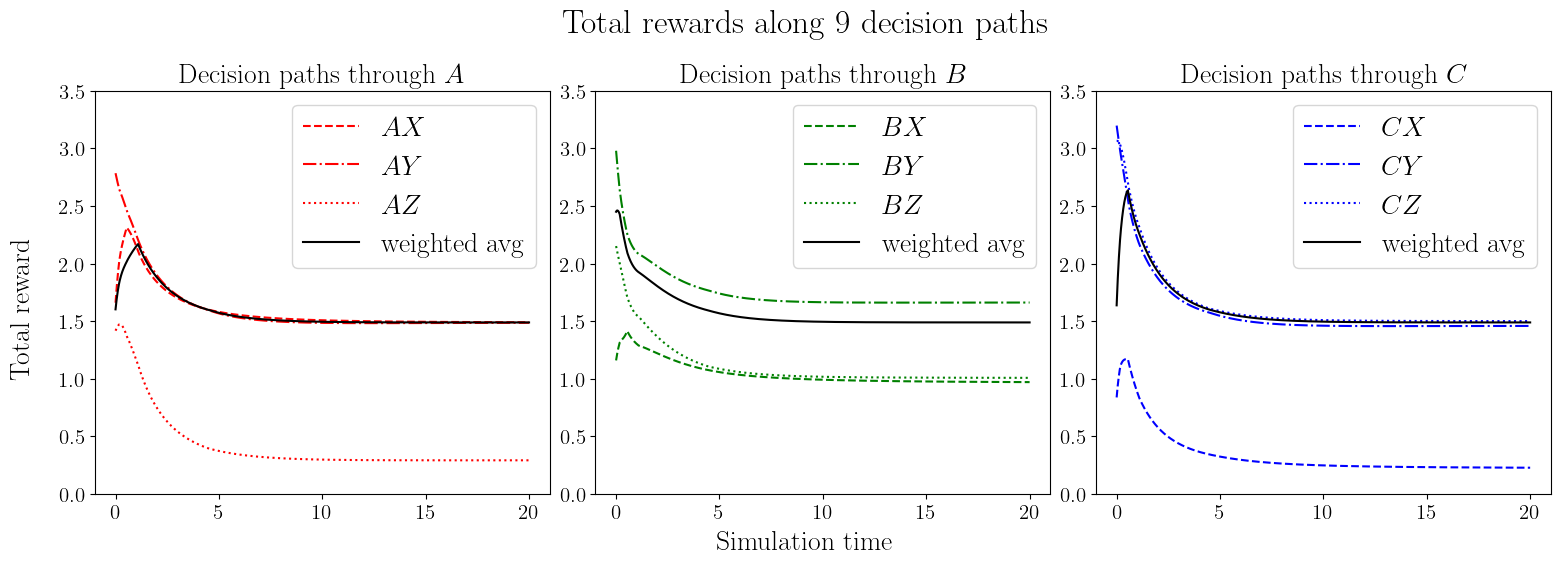

In [17]:
# fig for TCNS: rewards along 9 decision paths and group average
# print([resS21[-1,:]@resPathPi[-1,:3], resS22[-1,:]@resPathPi[-1,3:6], [resS23[-1,:]@resPathPi[-1,6:]]])

fs = 24
ss = 20
ts = 15
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), layout="constrained")

f.suptitle("Total rewards along 9 decision paths", y=1.1, fontsize=fs)
f.supxlabel("Simulation time", fontsize=ss)
f.supylabel("Total reward", x=-0.03, fontsize=ss)


for ax in axes:
  ax.set_ylim(0.0, 3.5)
  ax.tick_params(axis='x', labelsize=ts)
  ax.tick_params(axis='y', labelsize=ts)


axes[0].plot(t, resPathPi[:,0], 'r--', label='$AX$')
axes[0].plot(t, resPathPi[:,1], 'r-.', label='$AY$')
axes[0].plot(t, resPathPi[:,2], 'r:', label='$AZ$')
axes[0].set_title('Decision paths through $A$', fontsize=ss)

axes[1].plot(t, resPathPi[:,3], 'g--', label='$BX$')
axes[1].plot(t, resPathPi[:,4], 'g-.', label='$BY$')
axes[1].plot(t, resPathPi[:,5], 'g:', label='$BZ$')
axes[1].set_title('Decision paths through $B$', fontsize=ss)

axes[2].plot(t, resPathPi[:,6], 'b--', label='$CX$')
axes[2].plot(t, resPathPi[:,7], 'b-.', label='$CY$')
axes[2].plot(t, resPathPi[:,8], 'b:', label='$CZ$')
axes[2].set_title('Decision paths through $C$', fontsize=ss)

axes[0].plot(t, [resS21[i,:]@resPathPi[i,:3] for i in range(len(t))], 'k', label='weighted avg')
axes[1].plot(t, [resS22[i,:]@resPathPi[i,3:6] for i in range(len(t))], 'k', label='weighted avg')
axes[2].plot(t, [resS23[i,:]@resPathPi[i,6:] for i in range(len(t))], 'k', label='weighted avg')

for ax in axes:
  ax.legend(loc='upper right', fontsize=ss)

plt.savefig("rewards.pdf", format="pdf", bbox_inches="tight")


# Animation

In [ ]:
# # --- Setup Figure and Static Elements ---
# plt.rcParams['animation.embed_limit'] = 500
# ss = 24
# ms = 15
# ls = 15
# f = plt.figure(layout="constrained", figsize=(10, 10))
# ax = f.subplot_mosaic("""T""")
# ax["T"].set_aspect('equal')
# ax["T"].set_axis_off()

# # Plot the static ternary triangle boundary
# ax["T"].plot([0, 1, 1/2, 0], [0, 0, np.sqrt(3)/2, 0], 'k-', lw=2)

# # Label the vertices
# id_mtx = np.identity(3)
# res_vertices = transform_to2d(id_mtx)
# labels = [r'$R_1$', r'$R_2$', r'$R_3$']
# offsets = [(-0.04, -0.06), (-0.1, -0.02), (-0.04, -0.06)] # Adjusted for readability

# for i, data in enumerate(res_vertices):
#     ax["T"].text(data[0] + offsets[i][0], data[1] + offsets[i][1], labels[i], fontsize=ss)

# # --- Initialize Dynamic Plot Objects ---

# # Create the line object that will be updated
# line11, = ax["T"].plot([], [], 'k-', linewidth=3, label='S11')
# point11, = ax["T"].plot([], [], 'k*', markersize=ms, label='current state')
# line21, = ax["T"].plot([], [], 'r-', linewidth=3, label='S21')
# point21, = ax["T"].plot([], [], 'r*', markersize=ms, label='current state')
# line22, = ax["T"].plot([], [], 'g-', linewidth=3, label='S22')
# point22, = ax["T"].plot([], [], 'g*', markersize=ms, label='current state')
# line23, = ax["T"].plot([], [], 'b-', linewidth=3, label='S23')
# point23, = ax["T"].plot([], [], 'b*', markersize=ms, label='current state')
# line, = ax["T"].plot([], [], 'm-', linewidth=3, label='trajectory')
# point, = ax["T"].plot([], [], 'm*', markersize=ms, label='current state')
# ax["T"].legend(loc='upper right', fontsize=ls)

# # --- Animation Logic ---
# def init():
#     """Initialize background of the animation."""
#     line11.set_data([], [])
#     point11.set_data([], [])
#     line21.set_data([], [])
#     point21.set_data([], [])
#     line22.set_data([], [])
#     point22.set_data([], [])
#     line23.set_data([], [])
#     point23.set_data([], [])
#     line.set_data([], [])
#     point.set_data([], [])
#     return line11, line21, line22, line23, point11, point21, point22, point23, line, point

# def update(frame):
#     """Update plot for each frame."""
#     # Slice the trajectory up to the current frame
#     x = res_Traj[:frame, 0]
#     y = res_Traj[:frame, 1]

#     x11 = res_S11[:frame, 0]
#     y11 = res_S11[:frame, 1]

#     x21 = res_S21[:frame, 0]
#     y21 = res_S21[:frame, 1]

#     x22 = res_S22[:frame, 0]
#     y22 = res_S22[:frame, 1]

#     x23 = res_S23[:frame, 0]
#     y23 = res_S23[:frame, 1]

#     # one can uncomment the following to see the whole trajectories
#     line.set_data(x, y)
#     line11.set_data(x11, y11)
#     line21.set_data(x21, y21)
#     line22.set_data(x22, y22)
#     line23.set_data(x23, y23)

#     # Update the star to the current head of the trajectory
#     if frame > 0:
#         point.set_data([x[-1]], [y[-1]])
#         point11.set_data([x11[-1]], [y11[-1]])
#         point21.set_data([x21[-1]], [y21[-1]])
#         point22.set_data([x22[-1]], [y22[-1]])
#         point23.set_data([x23[-1]], [y23[-1]])

#     return line11, line21, line22, line23, point11, point21, point22, point23, line, point

# # Create the animation
# # frames: total number of steps in resX
# # interval: delay between frames in milliseconds
# step = 10
# ani = FuncAnimation(f, update, frames=range(0, len(res_Traj), step),
#                     init_func=init, blit=False, interval=20)

# # plt.show()

# # To save the animation, you would use:
# # ani.save('trajectory_animation.mp4', writer='ffmpeg')

# plt.close()
# ani